<hr style="border:2px solid black"></hr>

# Initialization

In [32]:
%load_ext autotime
%matplotlib inline

from toolbox.initialize import *


# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

<hr style="border:2px solid black"></hr>

# Cleaning

## Load dataframe

In [3]:
df_path = Config.Path.project_data_root / 'df_clean'
df = t.load_data_from_files(df_path, spark, method='parquet')
df.drop('user_id_prefix')

display_middle_results = True

Loading data from path: "/data/work/shared/s001284/Music_Project/resources/data/df_clean".
	Execution time: 0.74388 s.


## Count the rows

In [5]:
n_rows_total = df.count()

print(f'The total number of rows: {n_rows_total:,.0f}.')

The total number of rows: 2,530,475,843.


## Replace undefined cell vallues with null

In [4]:
# Save the start time for timing.
start_time = time.time()

# Define a function that will replace cells with empty 
# or undefined values with null.
def replace_invalid_with_null(column_name):
    return (f.when(((f.col(column_name) == '')
                   | (f.col(column_name) == '<unknown>')
                   | (f.col(column_name).contains( '�'))),
                  None)
            .otherwise(f.col(column_name))
           )

# Define the expression thaw will be used together with the 
# "select" statement to replace undefined values with null.
expression_replace_invalid_with_null = \
    [replace_invalid_with_null(column_name).alias(column_name)
     for column_name in df.columns]

# Execute the cleaning.
df_clean = df.select(*expression_replace_invalid_with_null)
    
# Show the top rows of the resulting dataframe.
if display_middle_results:
    df_clean.limit(100).toPandas().head()

# Show the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')

,user_id,activity_id,activity_start_time,activity_duration,device_id,device_name,track_artist,track_title,track_album,track_player,track_start_time,track_duration,track_id,track_uri,user_id_prefix
0,ed1fbdd5-32d3-4263-94ef-3450cf82364a,2c97fae4-74af-4c17-8718-9c432467fc8b-2017-01-10,2017-01-10 13:31:30.798,2602,c06fb3284aa1f9ea,E6553,Iyaz,So Big,Replay,Walkman,2017-01-10 14:05:44.539,107,None,content://media/external/audio/media/100444,ed
1,ed73490c-c303-4587-ab16-f088e4493f50,1d5c77e6-870c-4f0d-a76b-8ac5903f2b3f-2018-08-27,2018-08-27 11:13:13.601,1708,8b0b28d778aaba3f,G8342,None,The Jimi Hendrix Experience - All Along the Wa...,None,Walkman,2018-08-27 11:39:15.741,37,None,content://media/external/audio/media/1391,ed
2,ed00019c-6190-462c-9d34-836a56c74fad,eb78f26c-f7d2-4f23-a44e-c381534d6e0a-2015-05-31,2015-05-31 19:29:46.853,59,8ef01ab617b6942a,D6503,Tranzpotter,Journey,Tranzpotter,None,2015-05-31 19:29:46.853,45,None,content://media/external/audio/media/14,ed
3,ed87ece2-d69f-4de0-a891-d384d900248d,fdb8124b-98bf-45c6-b56f-e35b649bef2b-2015-10-29,2015-10-29 06:11:40.617,155,d4489e420d3d63cc,D6603,None,Rage Against The Marmottes - A Ta Santé (Vidéo...,Download,Walkman,2015-10-29 06:11:40.617,155,None,content://media/external/audio/media/106586,ed
4,ed1fbdd5-32d3-4263-94ef-3450cf82364a,2c97fae4-74af-4c17-8718-9c432467fc8b-2017-01-10,2017-01-10 13:31:30.798,2602,c06fb3284aa1f9ea,E6553,Phil Collins,Something Happened on the Way to Heaven,...But Seriously,Walkman,2017-01-10 14:07:31.310,268,None,content://media/external/audio/media/100344,ed


Execution time: 3.17965 s.


## Count the undefined cells in each columns

In [7]:
# Save the start time for timing.
start_time = time.time()

# Initialize the dict where the numbers will be stored
n_undefined = dict()

for column_name in df_clean.columns:
    n_undefined[column_name] = df_clean.where(f.col(column_name).isNull()).count()
    pct_undefined[column_name] = n_undefined[column_name] / n_rows_total * 100
    print(f'Number of undefined cells in column "{column_name}": '
          f'{n_undefined[column_name]} {pct_undefined[column_name]:.2f} %)')

# Show the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')

Number of undefined cells in column "user_id": 0 (0.00000 %)
Number of undefined cells in column "activity_id": 0 (0.00000 %)
Number of undefined cells in column "activity_start_time": 0 (0.00000 %)
Number of undefined cells in column "activity_duration": 0 (0.00000 %)
Number of undefined cells in column "device_id": 7253534 (0.28665 %)
Number of undefined cells in column "device_name": 7258178 (0.28683 %)
Number of undefined cells in column "track_artist": 710429434 (28.07493 %)
Number of undefined cells in column "track_title": 180364595 (7.12769 %)
Number of undefined cells in column "track_album": 127804616 (5.05062 %)
Number of undefined cells in column "track_player": 338135480 (13.36253 %)
Number of undefined cells in column "track_start_time": 0 (0.00000 %)
Number of undefined cells in column "track_duration": 0 (0.00000 %)
Number of undefined cells in column "track_id": 2033877221 (80.37529 %)
Number of undefined cells in column "track_uri": 496936211 (19.63805 %)
Number of un

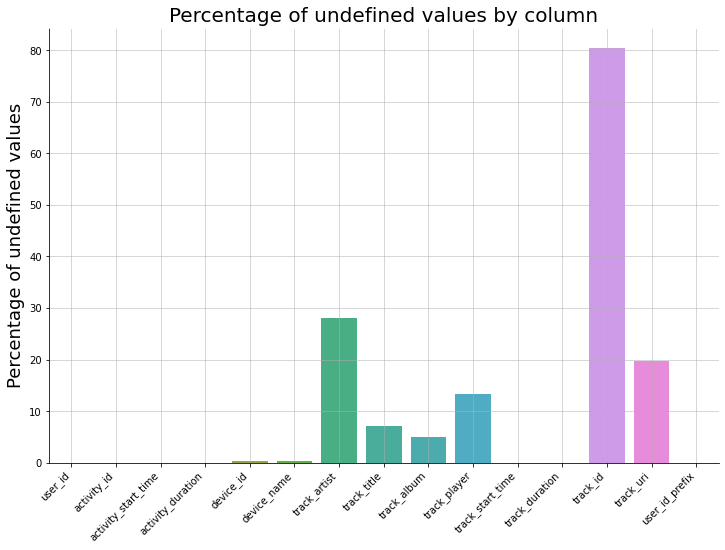

In [24]:
import seaborn as sns

pct_undefined = {column_name: n_undefined_in_column / n_rows_total * 100
                 for column_name, n_undefined_in_column
                 in n_undefined.items()}

axes = sns.barplot(x=list(pct_undefined.keys()), y=list(pct_undefined.values()))

labels = axes.set_xticklabels(axes.get_xticklabels(),
                              rotation=45, 
                              ha='right',
                              va='top')

title = axes.set_title('Percentage of undefined values by column')
# x_label = axes.set_xlabel('Column name')
y_label = axes.set_ylabel('Percentage of undefined values')

w.format_figure(axes.figure)

# figure, axes = w.empty_figure()
# axes.bar()

## Investigate activities over time

In [25]:
# Save the start time for timing.
start_time = time.time()

# Compute dataframe showing progress of Rome popularity per time
# Order by review date.
df_activity_over_time = (
    df_clean
    .groupBy('activity_start_time')
    .count()
    .orderBy(f.asc('activity_start_time'))
    )

# Show the top rows
df_activity_over_time.limit(100).toPandas().head(10)

# Show the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')

,activity_start_time,count
0,1970-01-01 10:13:17.640,1
1,1970-02-01 06:08:41.402,5
2,1970-02-01 06:46:14.571,8
3,2000-01-01 00:01:25.232,17
4,2013-06-11 15:27:50.300,3
5,2013-08-21 15:14:05.780,1
6,2013-09-04 18:09:54.913,1
7,2013-09-14 07:02:40.225,1
8,2013-09-14 11:45:38.080,4
9,2013-09-20 21:00:58.980,1


In [28]:
# Save the start time for timing.
start_time = time.time()

# Compute dataframe showing progress of Rome popularity per time
# Order by review date.
df_activity_stats = (
    df_clean
    .withColumn('activity_date', f.to_date('activity_start_time'))
    .groupBy('activity_date')
    .agg(f.count('activity_id').alias('n_activities'),
         f.sum('activity_duration').alias('activity_duration_sum'))
    .orderBy(f.asc('activity_date'))
)

# Show the top rows
df_activity_stats.limit(100).toPandas().head(10)
    
# Show the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')

,activity_date,n_activities,activity_duration_sum
0,1970-01-01,1,15
1,1970-02-01,13,20683
2,2000-01-01,17,35343
3,2013-06-11,3,873
4,2013-08-21,1,13
5,2013-09-04,1,1
6,2013-09-14,5,2008
7,2013-09-20,1,8
8,2013-09-26,12,26184
9,2013-09-28,1,18


Execution time: 761.29157 s.


In [29]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [33]:
# # Save the start time for timing.
# start_time = time.time()

df_activity_stats_pd = df_activity_stats.toPandas()

# # Show the execution time.
# print(f'Execution time: {time.time() - start_time:.5f} s.')

time: 12min 40s


In [40]:
import datetime


time: 489 µs


<AxesSubplot:xlabel='activity_date'>

Text(0.5, 1.0, 'Number of activities over time')

Text(0.5, 0, '')

Text(0, 0.5, 'Number of activities')

(16071.0, 18262.0)

Execution time: 5111.67361 s.


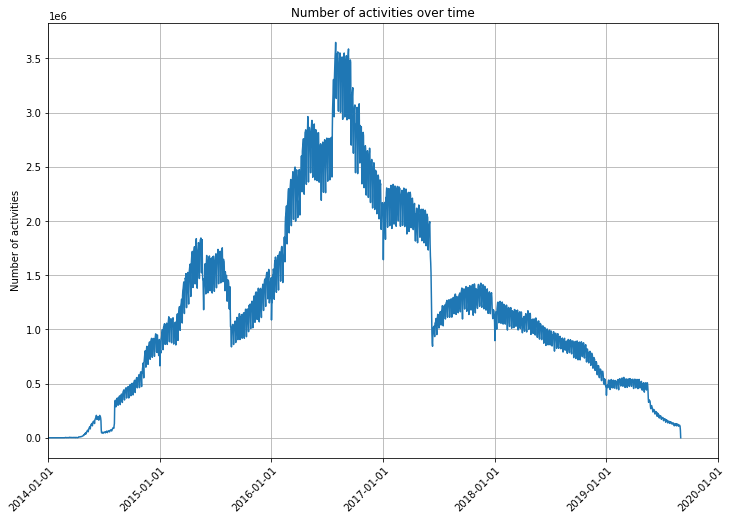

time: 199 ms


In [44]:
# Create a figure and axes for the plot.
figure, axes = w.empty_figure()

# Plot Rome popularity over time on the created axes
df_activity_stats_pd.plot(
    kind='line',
    color=sns.color_palette(),
    legend=False,
    ax=axes,
    x='activity_date',
    y=["n_activities"]
 )

# Format the axes
axes.grid()
axes.set_title('Number of activities over time')
axes.set_xlabel('')
axes.set_ylabel('Number of activities')
axes.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
axes.set_xlim((datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1)))
plot = plt.setp(axes.get_xticklabels(),
                rotation=45,
                ha="right",
                va='top',
                rotation_mode="anchor")

# Show the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')

<AxesSubplot:xlabel='activity_date'>

Text(0.5, 1.0, 'Time spend on activities over time')

Text(0.5, 0, '')

Text(0, 0.5, 'Sum of duration of activities')

(16071.0, 18262.0)

Execution time: 5161.75863 s.


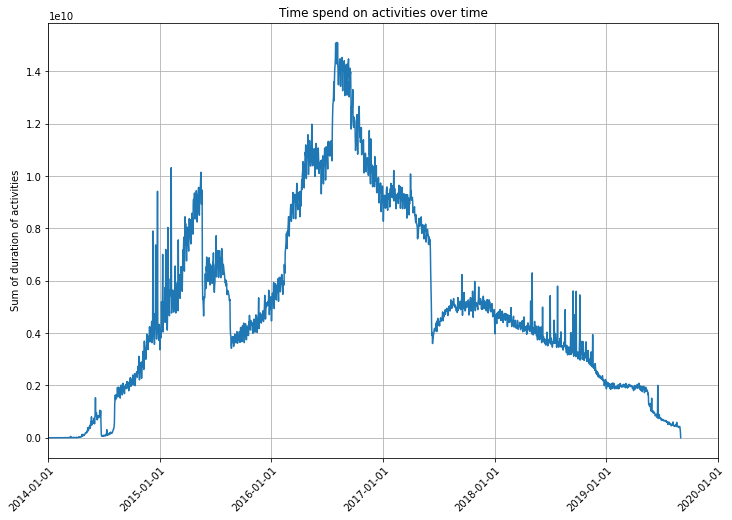

time: 201 ms


In [46]:
# Create a figure and axes for the plot.
figure, axes = w.empty_figure()

# Plot Rome popularity over time on the created axes
df_activity_stats_pd.plot(
    kind='line',
    color=sns.color_palette(),
    legend=False,
    ax=axes,
    x='activity_date',
    y=["activity_duration_sum"]
 )

# Format the axes
axes.grid()
axes.set_title('Time spend on activities over time')
axes.set_xlabel('')
axes.set_ylabel('Sum of duration of activities')
axes.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
axes.set_xlim((datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1)))
plot = plt.setp(axes.get_xticklabels(),
                rotation=45,
                ha="right",
                va='top',
                rotation_mode="anchor")

# Show the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')

In [36]:
# # Histogram
# buckets = [int(10*1.2**i) for i in range(0,30)]
# price_histogram = df_listings_rome.select('price').rdd.flatMap(lambda x: x).histogram(buckets)

def get_column(df, column_name):
    return df_activity_stats.select(column_name).rdd.flatMap(lambda x: x).collect()

date = get_column(df_activity_stats, 'activity_date')
n_activities = get_column(df_activity_stats, 'n_activities')
duration_sum = get_column(df_activity_stats, 'activity_duration_sum')

time: 31min 10s


TypeError: float() argument must be a string or a number, not 'PipelinedRDD'

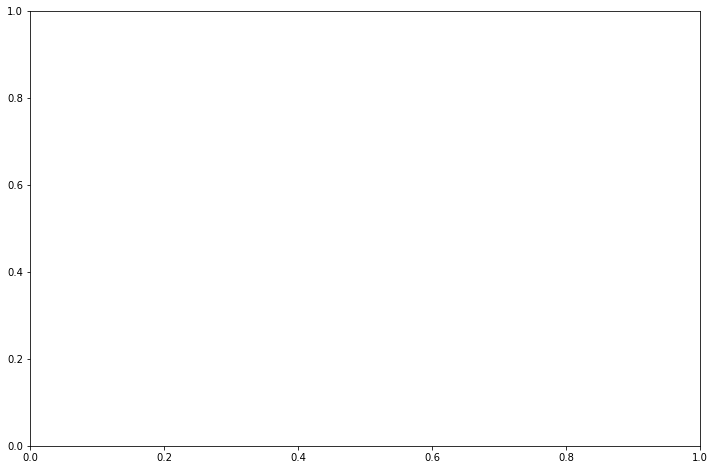

time: 216 ms


In [37]:
# Create a figure and axes for the plot.
figure, axes = w.empty_figure()

axes.plot(date, n_activities)

<hr style="border:2px solid black"></hr>

# Save the dataframe

In [ ]:
# Save the start time for timing.
start_time = time.time()

# Save the dataframe with partitions defined by the first
# two letters of the user ID.
(df_clean
 .withColumn('user_id_prefix', f.col('user_id').substr(0,2))
 .write.mode('overwrite')
 .partitionBy('user_id_prefix')
 .parquet(str(Config.Path.project_data_root / 'df_clean_new'))
)

# Print the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')